## Housing data

Boston House Prices¶

https://www.kaggle.com/datasets/vikrishnan/boston-house-prices

Each record in the database describes a Boston suburb or town. The data was drawn from the Boston Standard Metropolitan Statistical Area (SMSA) in 1970. The attributes are deﬁned as follows (taken from the UCI Machine Learning Repository1): CRIM: per capita crime rate by town

- **CRIM** per capita crime rate by town
- **ZN** proportion of residential land zoned for lots over 25,000 sq.ft.
- **INDUS** proportion of non-retail business acres per town
- **CHAS** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- **NOX** nitric oxides concentration (parts per 10 million)
- **RM** average number of rooms per dwelling
- **AGE** proportion of owner-occupied units built prior to 1940
- **DIS** weighted distances to five Boston employment centres
- **RAD** index of accessibility to radial highways
- **TAX** full-value property-tax rate per 10 000 USD
- **PTRATIO** pupil-teacher ratio by town
- **B 1000** (Bk - 0.63)^2 where Bk is the proportion of black people by town
- **LSTAT** % lower status of the population
- **MEDV** Median value of owner-occupied homes in $1000's

Missing values: None

Duplicate entries: None

This is a copy of UCI ML housing dataset. https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

In [3]:
df.shape

(506, 14)

### Visualise important characteristics

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cols = ['CRIM', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], height=1.5)
plt.tight_layout()
plt.show()

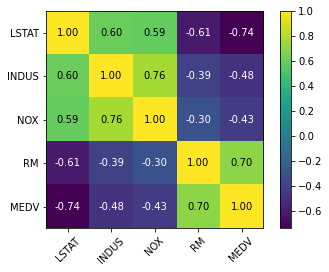

In [6]:
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df[cols].values.T)
(fig,ax) = heatmap(cm,
            row_names=cols,
            column_names=cols)
bottom, top = ax.get_ylim()
#ax.set_ylim(bottom + 0.5, top - 0.5) # This is needed for matplotlib 3.1.1 to compensate for bug
plt.show()

Back to presentation

## Regression parameter estimation with Gradient Descent

In [7]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        # Initialise by saving (possibly default) parameters
        self.eta = eta       # Step size
        self.n_iter = n_iter # Epochs

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1]) # Internal start weights
        self.cost_ = []                    # Internal start cost

        for i in range(self.n_iter):
            output = self.net_input(X) # Predict output
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors) # Update weights (derivative of cost function)
            self.w_[0] += self.eta * errors.sum()     # ------||------ (see Chapter 2 on Grad. Desc.)
            cost = (errors**2).sum() / 2.0            # Current cost (SSE)
            self.cost_.append(cost)
        return self

    def net_input(self, X): # Neural network name of prediction
        return X @ self.w_[1:] + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

#### Simple regression

In [8]:
X = df[['RM']].values
y = df['MEDV'].values

In [9]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
# StandardScaler expects 2D-array. np.newaxis adds second dimension, flatten() removes it again

In [10]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)
# No .score()-method implemented only .predict(). We will plot after showing plot types.

Back to presentation

#### Plot SSE as function of Epochs

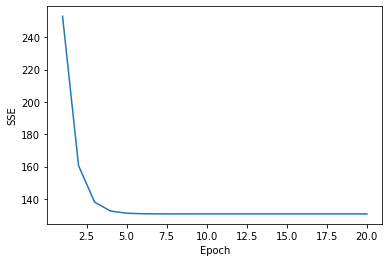

In [11]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

#### Plot target vs predictor

In [12]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return

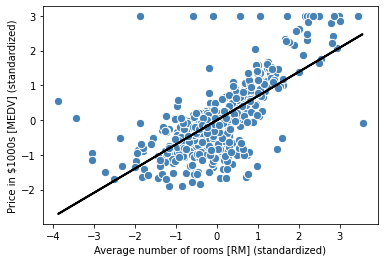

In [13]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [14]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [15]:
num_rooms_std = sc_x.transform(np.array([[6]])) # Scale (look at distributions above)
print("Number of rooms standardized: %.3f" % num_rooms_std)
price_std = lr.predict(num_rooms_std)
print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std[:,np.newaxis])) # "Un-scale"

Number of rooms standardized: -0.406
Price in $1000s: 19.942


## OLS via scikit-learn

In [16]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)             # Skipping standardization here
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


In [17]:
# Also in regression, ensembles can be used. 
# Here average prediction across regressors is the outcome.
from sklearn.ensemble import VotingRegressor
ereg = VotingRegressor([('slr', slr), ('slr2', slr)])
ereg.fit(X, y)

VotingRegressor(estimators=[('slr', LinearRegression()),
                            ('slr2', LinearRegression())])

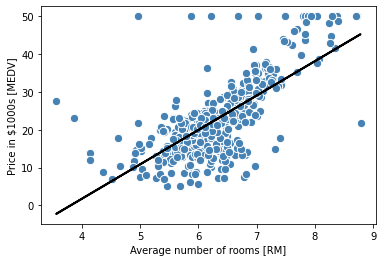

In [18]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
#plt.xlim([0,9])
#plt.ylim([-35,51])
plt.show()

Normal Equations alternative:

In [19]:
# adding a column vector of "ones"
Xb = np.hstack((np.ones((X.shape[0], 1)), X)) # Xb = [1 X]
w = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)     # (Xb'*Xb)^-1 * Xb' * y

print('Slope: %.3f' % w[1])
print('Intercept: %.3f' % w[0])

Slope: 9.102
Intercept: -34.671


- Guaranteed optimal solution for non-singular problems.
- Computationally infeasible for huge data sets.

### Diagonstic plot
We will split into training and test for illustration

In [20]:
df.shape

(506, 14)

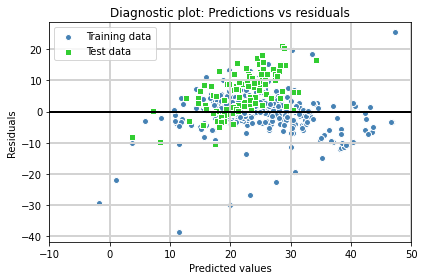

In [21]:
import matplotlib.pyplot as plt

X_train = df[['RM']].values[:400,:]
y_train = df['MEDV'].values[:400]
X_test  = df[['RM']].values[400:,:]
y_test  = df['MEDV'].values[400:]

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred  = slr.predict(X_test)

# Caluculate the residuals:
res_train = y_train_pred - y_train
res_test  = y_test_pred  - y_test

# Make the diagnostic plot
plt.scatter(y_train_pred, res_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred, res_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Diagnostic plot: Predictions vs residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()
plt.grid(color='LightGrey', linestyle='-', linewidth=2)
plt.show()

Are we satisfied with my manual train-test-split?

### Performance metrics to assess model "goodness"
Assume that $y^{(i)}$ are the true and predicted target values of sample number $(i)$ among $n$ samples. Then  
 - the __Mean Squared Error (MSE)__ is defined as $MSE = \frac{1}{n}SSE$, where $SSE =\sum_{i = 1}^{n}(y^{(i)}-\hat{y}^{(i)})^2$, i.e. the average value of the squared errors.
 - the __Mean Absolute Error (MAE)__ is defined as $MAE = \frac{1}{n}\sum_{i = 1}^{n}|y^{(i)}-\hat{y}^{(i)}|$, i.e. the average of the absolute errors.
 - the __Coefficient of Determination__ is defined as $R^2= 1 - \frac{SSE}{SST}$, where $SST = \sum_{i = 1}^{n}(y^{(i)}-\bar{y})^2$ and $\bar{y}=\frac{1}{n}y^{(i)}$ is the average target value.

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print('Mean squared error (MSE)  - train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2                       - train:  %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))
print('Mean absolute error (MAE) - train: %.3f,  test:  %.3f' % (
        mean_absolute_error(y_train, y_train_pred),
        mean_absolute_error(y_test, y_test_pred)))

Mean squared error (MSE)  - train: 36.303, test: 79.626
R^2                       - train:  0.567, test: -1.818
Mean absolute error (MAE) - train: 3.827,  test:  7.375


In [23]:
print('Root mean squared error (RMSE) - train: %.3f, test: %.3f' % (
        np.sqrt(mean_squared_error(y_train, y_train_pred)),
        np.sqrt(mean_squared_error(y_test, y_test_pred))))

Root mean squared error (RMSE) - train: 6.025, test: 8.923


Back to presentation

## High-dimensional data

### Sparseness in high dimensions
If samples are drawn from a $p$-dimensional uniform distribution, their average pair-wise distance depends on the number of dimensions, $p$.

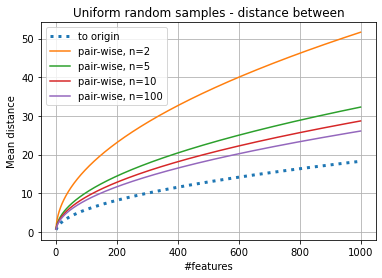

In [23]:
# Theoretical curves, distance between objects and distance object to origin
import numpy as np
import matplotlib.pyplot as plt
fe = np.array([1,2,3,5,10,20,50,100,200,500,1000,2000,5000,10000])
fe = np.logspace(0,3,1000)
uni_int = (-1,1)
L = uni_int[1]-uni_int[0]
plt.plot(fe, np.sqrt(fe/3-1/12), ':', label='to origin', linewidth=3)
plt.plot(fe, np.sqrt((fe-1/3)/6)*2/(2-1)*L, label='pair-wise, n=2')
plt.plot(fe, np.sqrt((fe-1/3)/6)*5/(5-1)*L, label='pair-wise, n=5')
plt.plot(fe, np.sqrt((fe-1/3)/6)*10/(10-1)*L, label='pair-wise, n=10')
plt.plot(fe, np.sqrt((fe-1/3)/6)*100/(100-1)*L, label='pair-wise, n=100')
plt.xlabel('#features')
plt.ylabel('Mean distance')
plt.title('Uniform random samples - distance between')
plt.legend()
plt.grid()
plt.show()

Spectral data are typically high-dimensional but only span a low dimensional subspace. PCA and PLS leverage this property.

#### Import NIR-data from MATLAB data file

In [24]:
import scipy.io
gasoline = scipy.io.loadmat('gasoline.mat')
# loadmat() converts data file to dictionary
gasoline.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Description', 'NIR', 'octane'])

In [25]:
gasoline['Description']

array(['== Spectral and octane data of gasoline ==                              ',
       '                                                                        ',
       'NIR spectra and octane numbers of 60 gasoline samples                   ',
       '                                                                        ',
       'NIR:     NIR spectra, measured in 2 nm intervals from 900 nm to 1700 nm ',
       'octane:  octane numbers                                                 ',
       'spectra: a dataset array containing variables for NIR and octane        ',
       '                                                                        ',
       'Reference:                                                              ',
       'Kalivas, John H., "Two Data Sets of Near Infrared Spectra," Chemometrics',
       'and Intelligent Laboratory Systems, v.37 (1997) pp.255–259              '],
      dtype='<U72')

In [26]:
gasoline['NIR'].shape

(60, 401)

#### Plot raw data

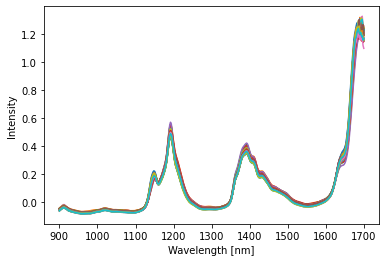

In [27]:
import matplotlib.pyplot as plt
wavelength = np.linspace(900, 1700, int((1700-900)/2+1))
plt.plot(wavelength,gasoline['NIR'].T)
plt.xlabel('Wavelength [nm]')
# plt.xlabel('Raman shift [cm-1]') # If these were Raman spectra
plt.ylabel('Intensity')
plt.show()

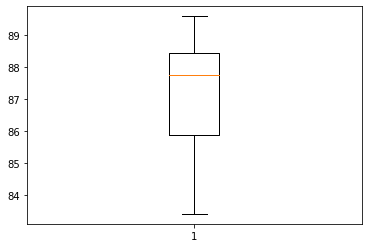

In [28]:
plt.boxplot(gasoline['octane'])
plt.show()

### PCA
#### Loadings

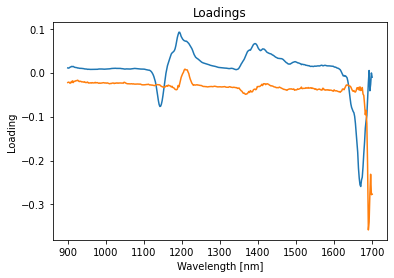

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(gasoline['NIR'])
plt.plot(wavelength,pca.components_.T)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Loading')
plt.title('Loadings')
plt.show()

#### Scores

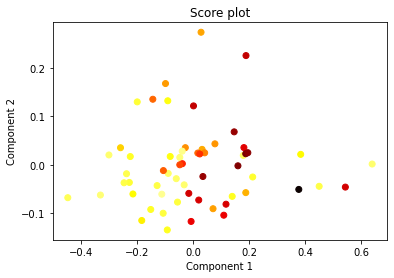

In [30]:
import matplotlib.cm as cm
scores = pca.transform(gasoline['NIR'])
plt.scatter(scores[:,0],scores[:,1], c = gasoline['octane'].flatten(), cmap=cm.hot)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Score plot')
plt.show()

In [31]:
gasoline['octane'].flatten().shape

(60,)

### Linear regression
Internally solved using numpy.linalg.lstsq (non-unique least-squares solution)

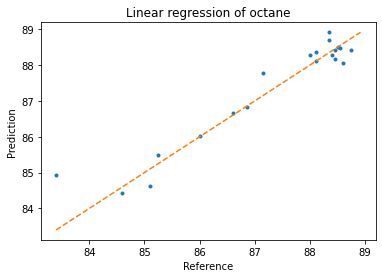

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =\
       train_test_split(gasoline['NIR'], gasoline['octane'], 
                        test_size=1/3, # 40:20 split
                        random_state=1)
slra = LinearRegression()
slra.fit(X_train, y_train)
y_pred = slra.predict(X_test)
plt.plot(y_test, y_pred, '.')
y_all = np.vstack([y_test,y_pred])
plt.plot([min(y_all),max(y_all)], [min(y_all),max(y_all)], '--')
plt.xlabel('Reference')
plt.ylabel('Prediction')
plt.title('Linear regression of octane')
plt.show()

### PLS regression

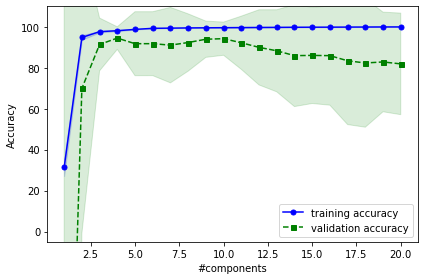

[-210.6635188    69.91476571   91.40647197   94.51917601   91.7793916
   91.796156     91.06956599   92.3552906    93.95790299   94.2349428
   92.23885635   89.98793947   88.31450542   85.94729102   86.05715988
   85.94175548   83.43411371   82.35768984   82.8644563    81.91315497]


In [33]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

pls = PLSRegression(scale=False)

# Validation curve for parameter estimation
param_range = list(range(1,21))
train_scores, test_scores = validation_curve(
                estimator=pls, 
                X=X_train, 
                y=y_train, 
                param_name='n_components', # The paramter to vary
                param_range=param_range,   # ... and its values
                cv=10)

# Calculate validation curves for training and test sets
train_mean = np.mean(train_scores, axis=1)*100
train_std = np.std(train_scores, axis=1)*100
test_mean = np.mean(test_scores, axis=1)*100
test_std = np.std(test_scores, axis=1)*100

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('#components')
plt.ylabel('Accuracy')
plt.ylim([-5, 110.0])
plt.tight_layout()
plt.grid()
plt.show()
print(test_mean)

### Compare linear regression and PLSR

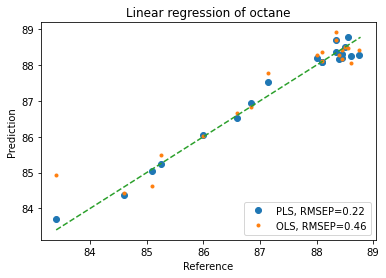

In [34]:
pls = PLSRegression(n_components=4, scale=False)
pls.fit(X_train, y_train)
y_predPLS = pls.predict(X_test)
y_all = np.vstack([y_test,y_predPLS])

RMSEPP = np.sqrt(np.mean(np.power(y_test-y_predPLS, 2)))
RMSEP  = np.sqrt(np.mean(np.power(y_test-y_pred, 2)))

plt.plot(y_test, y_predPLS, 'o', label="PLS, RMSEP={0:.2f}".format(RMSEPP))
plt.plot(y_test, y_pred, '.', label="OLS, RMSEP={0:.2f}".format(RMSEP))
plt.plot([min(y_all),max(y_all)], [min(y_all),max(y_all)], '--')
plt.xlabel('Reference')
plt.ylabel('Prediction')
plt.title('Linear regression of octane')
plt.legend(loc='lower right')
plt.show()

In [35]:
T_test = pls.transform(X_test)

#### PLS regression as a dimension reductor in a pipeline
scikit-learn implementation struggles if .transform(X) is needed in combination with a pipeline used with .fit(X,Y)

In [36]:
class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X) # Only use X for transform when both X and Y are supplied

In [45]:
my_pipe = make_pipeline(PLSRegressionWrapper(n_components=4, scale=False), LinearRegression())
my_pipe.fit(X_train,y_train)

Pipeline(steps=[('plsregressionwrapper',
                 PLSRegressionWrapper(n_components=4, scale=False)),
                ('linearregression', LinearRegression())])

### Supspace plotting

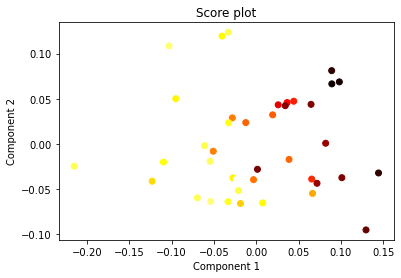

In [38]:
plt.scatter(pls.x_scores_[:,1],pls.x_scores_[:,2], c = y_train.flatten(), cmap=cm.hot)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Score plot')
plt.show()

In [40]:
pls.x_weights_

array([[-4.03146397e-03, -1.64129457e-02, -5.45661375e-02,
        -4.48636429e-03],
       [-2.31852849e-03, -1.82360608e-02, -5.19394150e-02,
        -2.38675755e-04],
       [-1.40598375e-03, -2.02669570e-02, -5.08209232e-02,
         3.50059010e-03],
       ...,
       [ 3.26412875e-02, -1.86940112e-02,  2.52545598e-01,
        -9.20389678e-02],
       [-4.02517064e-02,  3.21456638e-02,  1.43027572e-01,
         8.27291082e-02],
       [ 2.08694392e-02, -2.60989084e-02,  1.88572252e-01,
        -1.25929878e-01]])

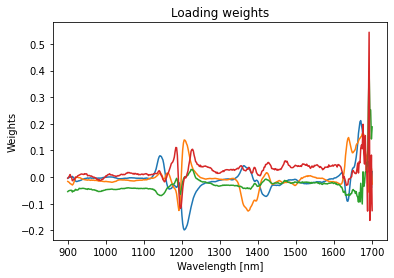

In [44]:
plt.plot(wavelength,pls.x_weights_)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Weights')
plt.title('Loading weights')
plt.show()

Back to presentation

## RANSAC

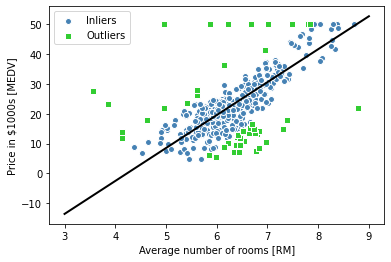

In [28]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100,         # Number of iterations of the loop
                         min_samples=50,         # Minimum random sample size
                         loss='absolute_error',  # Loss function for outliers (vertical distance)
                         residual_threshold=10.0,# Maximum vertical distance in MAD units (test me!)
                         stop_score=0.99,        # Stop searching if inliers score >= 0.99
                         random_state=0)

ransac.fit(X, y)

# Final choice of inliers and outliers
inlier_mask = ransac.inlier_mask_          
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1) # Regression line
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [29]:
# From RANSAC estimated inliers:
print('Score: %.3f' % ransac.score(X,y))
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)
print('Iterations applied: %d' % ransac.n_trials_)

Score: 0.462
Slope: 11.026
Intercept: -46.621
Iterations applied: 100


In [30]:
# From all data points:
print('Score: %.3f' % slr.score(X,y))
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Score: 0.462
Slope: 9.406
Intercept: -35.261


Back to presentation